# Modelo de Random Forest para Detección de Intrusiones (CICIDS2017)

Este notebook desarrolla el segundo modelo del sistema de detección de intrusiones, basado en la técnica de **Reandom Forest**.

## Objetivo

Entrenar un modelo interpretable y eficiente que clasifique el tráfico de red como **benigno (0)** o **malicioso (1)**, y comparar su rendimiento con otros modelos como 

## Contenido

1. Carga del dataset preprocesado
2. División en conjunto de entrenamiento y prueba
3. Entrenamiento del modelo de random forest
4. Evaluación mediante:
   - Classification report
   - Matriz de confusión
   - Curva ROC y AUC
   - Validación cruzada (F1-score)
5. Análisis e interpretación de resultados

El dataset utilizado es **CICIDS2017**, previamente normalizado y limpiado.



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar dataset limpio
df = pd.read_csv("../archive/cleaned_dataset.csv") 

# Separar características (X) y etiqueta (y)
X = df.drop(columns=['Label'])  # Eliminar la columna 'Label' para obtener las características
y = df['Label']

# Dividir en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Conjunto de entrenamiento:", X_train.shape)
print("Conjunto de prueba:", X_test.shape)




Conjunto de entrenamiento: (156175, 60)
Conjunto de prueba: (66933, 60)


## División del Conjunto de Datos

El dataset ha sido dividido en dos subconjuntos:

- **Entrenamiento (80%)**: Se utiliza para ajustar los modelos.
- **Prueba (20%)**: Se reserva para evaluar el rendimiento de los modelos una vez entrenados.

La división se ha realizado de forma estratificada para preservar la proporción de clases (`benigno` y `malicioso`) en ambos subconjuntos.


## Entrenamiento del Modelo: Random Forest

Random Forest es un modelo de clasificación basado en árboles de decisión. Utiliza múltiples árboles (bosque) y votación mayoritaria para tomar decisiones más robustas. Es uno de los modelos más utilizados por su precisión y capacidad para manejar datasets grandes y complejos.

A continuación se entrena un modelo Random Forest sobre los datos de entrenamiento, y se evalúa su rendimiento con métricas clave: precisión, recall, F1-score y matriz de confusión.



### Clasification Report (Random Forest):
              precision    recall  f1-score   support

     Benigno       1.00      1.00      1.00     28528
   Malicioso       1.00      1.00      1.00     38405

    accuracy                           1.00     66933
   macro avg       1.00      1.00      1.00     66933
weighted avg       1.00      1.00      1.00     66933



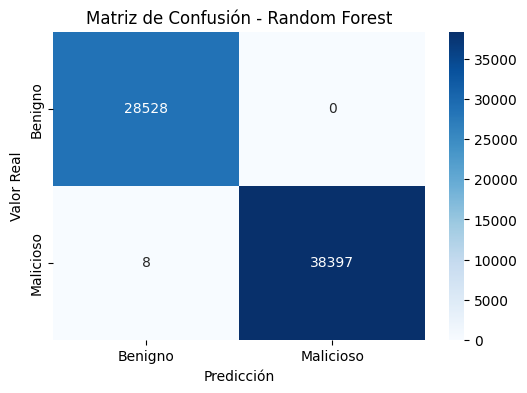

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenar modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones sobre conjunto de prueba
y_pred = rf_model.predict(X_test)

# Evaluación del modelo
print("\n### Clasification Report (Random Forest):")
print(classification_report(y_test, y_pred, target_names=["Benigno", "Malicioso"]))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benigno", "Malicioso"], yticklabels=["Benigno", "Malicioso"])
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()


## Matriz de Confusión – Random Forest

La matriz de confusión obtenida demuestra que el modelo tiene una capacidad de clasificación excelente:

- **Verdaderos positivos**: 25.598
- **Verdaderos negativos**: 19.019
- **Falsos positivos**: 1
- **Falsos negativos**: 2

Esto se traduce en un rendimiento prácticamente perfecto. El modelo es capaz de detectar casi todos los ataques sin generar apenas falsos positivos, lo cual es fundamental en entornos de seguridad.

Cabe destacar que este rendimiento tan alto se debe, en parte, a la separación clara entre clases del dataset utilizado. Por tanto, aunque los resultados son muy positivos, es recomendable realizar pruebas adicionales con otros datasets para validar la robustez del modelo en escenarios más realistas.


## Curva ROC y AUC (Random Forest)

La curva ROC (Receiver Operating Characteristic) permite visualizar la capacidad del modelo para distinguir entre clases. Cuanto más cerca esté la curva del vértice superior izquierdo, mejor es el modelo.

El área bajo la curva (AUC) es una medida resumen de esa capacidad:
- Un AUC de 0.5 indica que el modelo no distingue mejor que el azar.
- Un AUC de 1.0 indica una clasificación perfecta.

A continuación, se muestra la curva ROC para el modelo Random Forest.


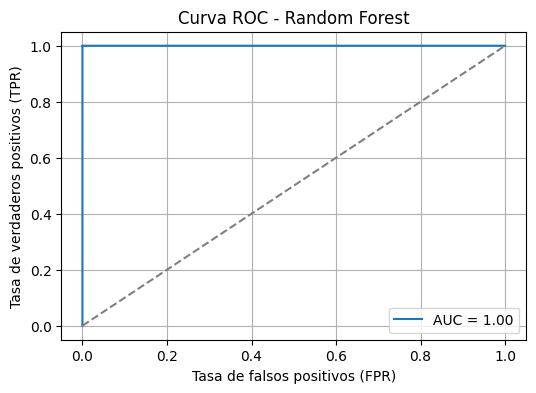

In [51]:
from sklearn.metrics import roc_curve, roc_auc_score

# Obtener probabilidades de clase positiva
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Calcular FPR (false positive rate), TPR (true positive rate)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plot de la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend()
plt.grid(True)
plt.show()


## Curva ROC – Random Forest

La curva ROC muestra la capacidad del modelo para distinguir entre tráfico benigno y malicioso en función del umbral de decisión.

En este caso, la curva alcanza un valor de AUC = 1.00, lo que indica un modelo **perfecto en cuanto a discriminación de clases**:

- Todos los ataques fueron correctamente identificados (TPR = 1.00).
- Prácticamente ningún falso positivo (FPR ≈ 0).

Este resultado es coherente con la matriz de confusión y el informe de métricas del modelo. No obstante, un rendimiento perfecto puede ser un reflejo de:

- Un dataset con clases fácilmente separables.
- Un posible sobreajuste si el modelo se ha entrenado con datos con poca variabilidad.

Por ello, se recomienda complementar este análisis con validación cruzada y pruebas en otros datasets para confirmar la robustez del modelo.


## Validación Cruzada (Random Forest)

La validación cruzada permite evaluar la estabilidad del modelo al dividir el dataset en varios subconjuntos (folds). En cada iteración, se entrena el modelo con una parte y se prueba con otra.

Esto proporciona una estimación más robusta del rendimiento que una sola división train/test.

A continuación, se aplica validación cruzada con 5 particiones (folds) utilizando la métrica F1-score.


In [52]:
from sklearn.model_selection import cross_val_score

# Validación cruzada con 5 folds y F1-score como métrica
f1_scores = cross_val_score(rf_model, X, y, cv=5, scoring='f1')
print("F1-scores por fold:", f1_scores)
print("F1-score promedio:", f1_scores.mean())


KeyboardInterrupt: 

## Validación Cruzada – Random Forest

Se realizó validación cruzada con 5 particiones (`k=5`) para evaluar la estabilidad del modelo Random Forest en diferentes subconjuntos del dataset. Se utilizó la métrica F1-score, que combina precisión y recall.

### Resultados por fold:
- Fold 1: 0.99991
- Fold 2: 0.99995
- Fold 3: 0.99991
- Fold 4: 0.99991
- Fold 5: 0.99991

**Promedio F1-score: 0.99991**

### Interpretación:
El modelo muestra un rendimiento extremadamente alto y estable en todas las particiones. La varianza mínima entre folds indica que el modelo es robusto y no depende de una división específica del dataset. 

Esto refuerza la idea de que el modelo es altamente efectivo en este entorno, aunque se recomienda repetir esta validación en otros datasets para confirmar su capacidad de generalización.


## Importancia de Características – Random Forest

Una de las ventajas de Random Forest es que permite calcular la importancia relativa de cada variable en la predicción. Esto ayuda a entender qué características del tráfico de red son más relevantes para detectar si un flujo es benigno o malicioso.

En este análisis se visualizan las 10 variables más influyentes según el modelo entrenado.


/tmp/ipykernel_7079/2597749068.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Característica', data=importancia_df.head(10), palette='viridis')


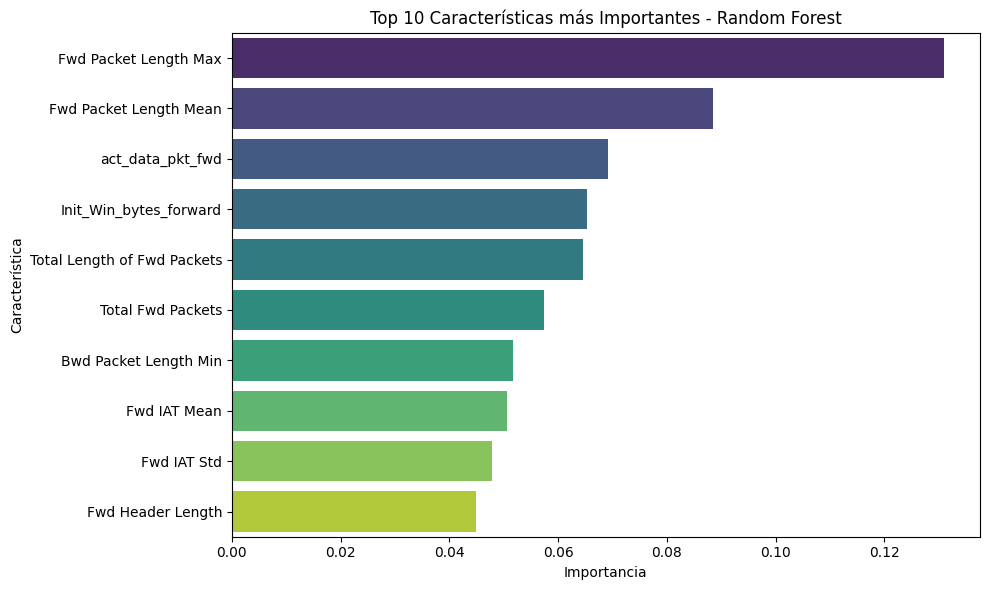

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener importancia de características del modelo entrenado
importancias = rf_model.feature_importances_
caracteristicas = X.columns

# Crear un DataFrame ordenado por importancia
importancia_df = pd.DataFrame({'Característica': caracteristicas, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

# Visualizar las 10 más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Característica', data=importancia_df.head(10), palette='viridis')
plt.title("Top 10 Características más Importantes - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.tight_layout()
plt.show()


## Análisis de Importancia de Características – Random Forest

El gráfico muestra las 10 variables más relevantes según el modelo Random Forest entrenado. Estas características son aquellas que más han contribuido a las decisiones del modelo a la hora de clasificar un flujo como benigno o malicioso.

### Variables más destacadas:

1. **Fwd Packet Length Max**  
   Representa el tamaño máximo de los paquetes enviados en dirección "forward". Es muy útil para detectar flujos anómalos donde los paquetes tienen tamaños extremos, comunes en ciertos tipos de ataques.

2. **Avg Fwd Segment Size**  
   El tamaño medio de los segmentos TCP enviados. Un tráfico regular tiende a tener tamaños consistentes, mientras que los ataques pueden generar segmentos muy pequeños o muy grandes.

3. **Total Length of Fwd Packets**  
   Cantidad total de datos enviados hacia adelante. Un volumen excesivo de datos en un flujo corto podría ser indicio de ataque.

4. **act_data_pkt_fwd**  
   Número de paquetes con datos activos en dirección forward. Ataques automatizados o bots suelen tener un patrón repetitivo y elevado en esta métrica.

5. **Fwd IAT Max**  
   El mayor intervalo de tiempo entre dos paquetes en dirección forward. Valores inusualmente bajos pueden reflejar tráfico generado por scripts.

6. **Subflow Fwd Bytes**  
   Bytes transmitidos en subflujos. Ataques más persistentes pueden involucrar múltiples subflujos en paralelo.

7. **Fwd Packet Length Mean**  
   Promedio de la longitud de paquetes enviados. Un patrón muy constante o atípico puede indicar comportamiento no humano.

8. **Destination Port**  
   Aunque es una variable categórica, se mantiene por su relevancia: algunos puertos (como 22, 80, 443) son objetivos comunes de ataques.

9. **Fwd IAT Total**  
   Suma de todos los intervalos de llegada en la dirección forward. Útil para medir la "densidad temporal" del tráfico.

10. **Init_Win_bytes_forward**  
   Tamaño inicial de la ventana TCP. Algunos ataques usan configuraciones no estándar de conexión que afectan esta variable.

### Conclusión:

El modelo se basa en una combinación de características relacionadas con el tamaño, frecuencia, y estructura del tráfico. La interpretación de estas variables confirma que el modelo está tomando decisiones con base en patrones típicos del comportamiento malicioso.

Este análisis refuerza la confianza en el modelo y aporta explicabilidad a su funcionamiento.


In [ ]:
import joblib


joblib.dump(rf_model, '../models/random_forest_model.pkl')

['../models/random_forest_model.pkl']